In [160]:
import pandas as pd
from sqlalchemy import create_engine, text

In [161]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')

import data_processing as proc
import utils
import performance as perf


In [162]:
import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [163]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

In [164]:
sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])

In [165]:
k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']


In [166]:
k200_df=k200_df.sort_index(level='Dates')

In [167]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

In [168]:
period1='2014-09-01'
period2='2024-07-31'

In [169]:
query_COM=f"select * from COM_Table where Dates>='{period1}' and Dates<='{period2}'"
data_COM=pd.read_sql(query_COM, conn)

data_COM.set_index(['Dates','Symbol'], inplace=True)
data_COM_nodup=data_COM.loc[~data_COM.index.duplicated(keep='last')].copy()

query_SSC=f"select * from SSC where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

data_SSC.set_index(['Dates','Symbol'], inplace=True)


Exception during reset or similar
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.11/site-packages/pymysql/connections.py", line 803, in _write_bytes
    self._sock.sendall(data)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.11/site-packages/sqlalchemy/pool/base.py", line 988, in _finalize_fairy
    fairy._reset(
  File "/opt/miniconda3/lib/python3.11/site-packages/sqlalchemy/pool/base.py", line 1438, in _reset
    pool._dialect.do_rollback(self)
  File "/opt/miniconda3/lib/python3.11/site-packages/sqlalchemy/engine/default.py", line 692, in do_rollback
    dbapi_connection.rollback()
  File "/opt/miniconda3/lib/python3.11/site-packages/pymysql/connections.py", line 487, in rollback
    self._execute_command(COMMAND.COM_QUERY, "ROLLBACK")
  File "/opt/miniconda3/lib/python3.11/site-packages/pymysql/connections.p

In [171]:
data_COM_nodup=data_COM.loc[~data_COM.index.duplicated(keep='last')].copy()

In [218]:
query_SSC=f"select * from SSC where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

In [219]:
data_SSC.set_index(['Dates','Symbol'], inplace=True)

In [225]:
data_SSC_nodup=data_SSC.loc[~data_SSC.index.duplicated(keep='last')].copy()

In [226]:
data_SSC.columns

Index(['Name', 'MNGT', 'ClosePrc', 'OpenPrc', 'HighPrc', 'LowPrc', 'AdjPrc',
       'AdjPrc2', 'AdjPrc_High_20D', 'AdjPrc_Low_20D', 'AdjPrc_High_60D',
       'AdjPrc_Low_60D', 'AdjPrc_High_120D', 'AdjPrc_Low_120D',
       'AdjPrc_High_52W', 'AdjPrc_Low_52W', 'ListedShares', 'ForeignStake',
       'TradeStop', 'MktCap_Comm_Pref', 'MktCapCom', 'MktCap', 'Volume',
       'Volume_Avg_20D', 'Volume_Avg_60D', 'Volume_Avg_120D', 'Volume_Avg_52W',
       'Amt_Avg_20D', 'Amt_Avg_60D', 'Amt_Avg_120D', 'Amt_Avg_52W', 'Vol_20D',
       'Vol_120D'],
      dtype='object')

In [227]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [228]:
query_idx=f"select * from krx_idx"
krx_idx=pd.read_sql(query_idx, conn)

In [229]:
krx_idx.set_index('Dates', inplace=True)

# backtesting

In [230]:
adjprc=data_SSC_nodup['AdjPrc'].unstack()
adjprc=adjprc.astype(float)

In [231]:
data_path='../data/output/prob_out/'
# file_name='multilayer_factor_rolling_v1.0_2024-03-29_ver0.1.csv'
# file_name='prob_res_2014-01-29_2024-02-29_ver0.1.csv'
# file_name='prob_res_2014-01-29_2024-05-31_ver0.1.csv'
file_name='prob_res_2014-01-29_2024-07-31_ver0.1.csv'
# hyungshin.lee/data/output/prob_out/prob_res_2013-01-25_2023-08-31.csv
raw_prob=pd.read_csv(data_path+file_name, index_col=0)

# mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)

In [232]:
raw_prob.index

Index(['2024-05-10', '2024-05-17', '2024-05-24', '2024-05-31', '2024-06-07',
       '2024-06-14', '2024-06-21', '2024-06-28', '2024-07-05', '2024-07-12',
       '2024-07-19', '2024-07-26', '2024-07-31'],
      dtype='object', name='Dates')

In [233]:
raw_prob

,A000080,A000100,A000120,A000150,A000210,A000240,A000270,A000660,A000670,A000720,...,A383220,A402340,A022100,A450080,A003030,A005070,A042700,A066970,A454910,A457190
Dates,,,,,,,,,,,,,,,,,,,,,
2024-05-10,0.027426,0.026696,0.018369,0.017833,0.016739,0.026566,0.020192,0.023206,0.011626,0.016345,...,0.019404,0.027014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-17,0.025077,0.026899,0.018660,0.017638,0.018429,0.029682,0.020867,0.000604,0.010981,0.016240,...,0.018148,0.025116,0.026251,0.036338,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-24,0.026539,0.028090,0.018898,0.018605,0.019873,0.030185,0.022260,0.019501,0.010119,0.015459,...,0.018124,0.025711,0.025986,0.042304,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,0.027029,0.029641,0.018603,0.019014,0.020647,0.030371,0.022214,0.031885,0.011123,0.014437,...,0.021114,0.026917,0.026060,0.046578,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-07,0.025978,0.022174,0.023212,0.020695,0.022880,0.026981,0.022404,0.009432,0.019328,0.022766,...,0.026413,0.020079,0.020795,0.024976,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-14,0.025082,0.023015,0.023704,0.020739,0.023102,0.026480,0.024002,0.011918,0.019382,0.023199,...,0.026297,0.021047,0.023864,0.026133,0.027117,0.024318,0.012865,0.022284,0.023982,0.027788
2024-06-21,0.024374,0.023943,0.023902,0.020629,0.023493,0.025932,0.025581,0.012839,0.019621,0.023605,...,0.026003,0.020613,0.024653,0.023798,0.027266,0.024689,0.012418,0.022694,0.023427,0.028237
2024-06-28,0.023661,0.024020,0.023773,0.020354,0.023851,0.025406,0.026870,0.014966,0.019192,0.025152,...,0.025999,0.020751,0.025603,0.023209,0.027755,0.024922,0.012789,NaN,0.023608,0.027408
2024-07-05,0.006214,0.005322,0.005287,0.004068,0.004957,0.006045,0.004565,0.001342,0.004995,0.005913,...,0.007536,0.002573,0.005461,0.003505,0.007867,0.005718,0.000858,0.008106,0.005251,0.009344


In [234]:
# raw_prob.reset_index(inplace=True)
# raw_prob.set_index(['Dates', 'Symbol'], inplace=True)
# raw_prob=raw_prob.unstack()
# raw_prob.columns=raw_prob.columns.get_level_values(1)

In [185]:
raw_prob.index = pd.to_datetime(raw_prob.index)

In [189]:
# use existing weight with shift1

In [190]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [191]:
scaler = StandardScaler()
tempw = scaler.fit_transform(raw_prob.iloc[0].dropna().values.reshape(-1, 1))
temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[0].dropna().index)

In [192]:
temp_w=temp_w/abs(temp_w).sum()

In [193]:
temp_w

,0
A000080,0.002755
A000100,0.002194
A000120,-0.004210
A000150,-0.004622
A000210,-0.005464
...,...
A373220,0.013069
A375500,-0.005952
A377300,0.007309
A383220,-0.003414


In [194]:
raw_prob.iloc[-1].sort_values().dropna()

A005930    0.000157
A267260    0.000513
A003230    0.001475
A000660    0.001705
A012450    0.001871
             ...   
A004170    0.008944
A383220    0.008983
A377300    0.009027
A457190    0.009738
A111770    0.009896
Name: 2024-07-31 00:00:00, Length: 200, dtype: float64

In [195]:
ls_weight_ls = []
len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob.iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[i].dropna().index)
    
    # remove top bottom +/- 2stdev
    temp_w[temp_w>(temp_w.mean()+2*temp_w.std())]=2
    temp_w[temp_w<(temp_w.mean()-2*temp_w.std())]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w=temp_w/abs(temp_w).sum()
    len_ls.append(len(temp_w[temp_w>0].dropna()))
    ls_weight_ls.append(temp_w)
    

In [197]:
ls_w=pd.concat(ls_weight_ls, axis=1).T
ls_w.index=raw_prob.index

In [40]:
temp_ls_w=ls_w.copy()
temp_ls_w.loc[:, 'A001570']=0

In [41]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

/tmp/ipykernel_309735/3876697821.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)


In [42]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

/tmp/ipykernel_309735/3876697821.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)


In [43]:
long_w=ls_w[temp_ls_w>0]
short_w=ls_w[temp_ls_w<0]

In [199]:
ew_long=long_w.copy()
ew_short=short_w.copy()

In [200]:
ew_long[ew_long>0]=1
ew_short[ew_short<0]=-1

In [201]:
ew_long=ew_long.div(ew_long.count(1), axis=0)
ew_short=ew_short.div(ew_short.count(1), axis=0)

In [235]:
long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2

/tmp/ipykernel_309735/425279764.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
/tmp/ipykernel_309735/425279764.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2


In [236]:
ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)

/tmp/ipykernel_309735/4102127311.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
/tmp/ipykernel_309735/4102127311.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)


# LS results

In [237]:
long_w.loc['2023-06-01': '2023-12-01', 'A001570'].fillna(0)

Series([], Name: A001570, dtype: float64)

In [239]:
ls_w.loc['2023-06-01':].index

DatetimeIndex(['2024-05-10', '2024-05-17', '2024-05-24', '2024-05-31',
               '2024-06-07', '2024-06-14', '2024-06-21', '2024-06-28',
               '2024-07-05', '2024-07-12', '2024-07-19', '2024-07-26',
               '2024-07-31'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [240]:
adjprc.loc[ls_w.loc['2023-06-01':].index, 'A001570'].pct_change()

Dates
2024-05-10         NaN
2024-05-17   -0.031536
2024-05-24   -0.106092
2024-05-31   -0.021152
2024-06-07    0.080432
2024-06-14   -0.016667
2024-06-21   -0.082486
2024-06-28    0.059113
2024-07-05   -0.034884
2024-07-12   -0.021687
2024-07-19   -0.068966
2024-07-26   -0.120370
2024-07-31    0.015038
Name: A001570, dtype: float64

In [241]:
idx_ret['A001570'].dropna()

Dates
2024-04-12   -0.0
2024-04-19   -0.0
2024-04-26   -0.0
2024-05-03    0.0
2024-05-10    0.0
2024-05-17   -0.0
2024-05-24   -0.0
2024-05-31   -0.0
2024-06-07    0.0
2024-06-14   -0.0
2024-06-21   -0.0
2024-06-28    0.0
Name: A001570, dtype: float64

<Axes: xlabel='Dates'>

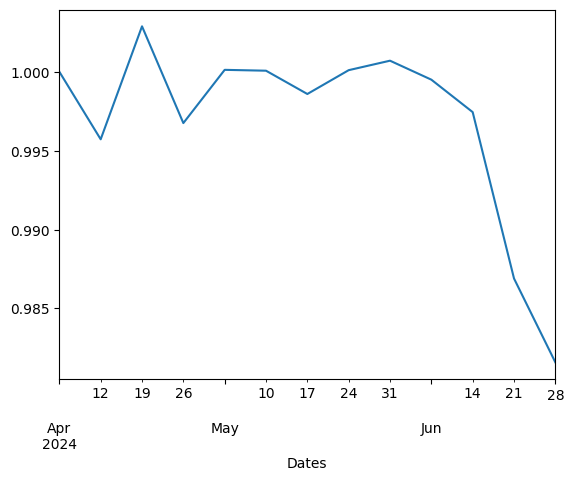

In [242]:
# raw long short 
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

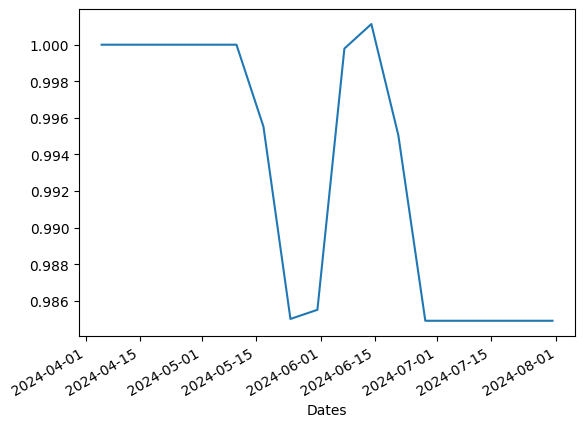

In [243]:
# raw long
(1+long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

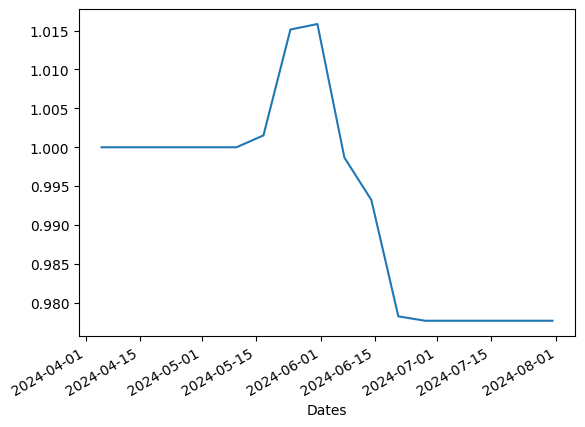

In [244]:
# raw short
(1+short_idx_ret.sum(1)).cumprod().plot()

In [245]:
# equal weight long short

<Axes: xlabel='Dates'>

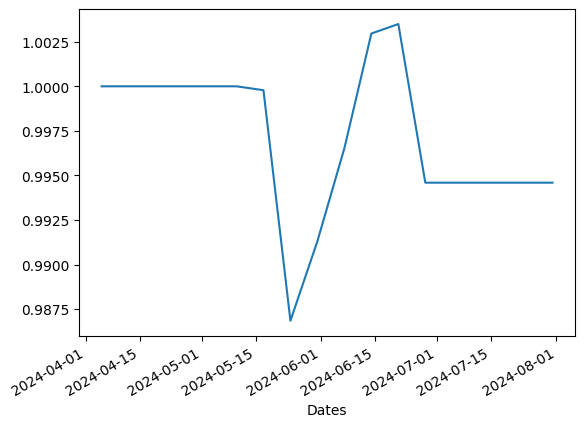

In [246]:
(1+ew_long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

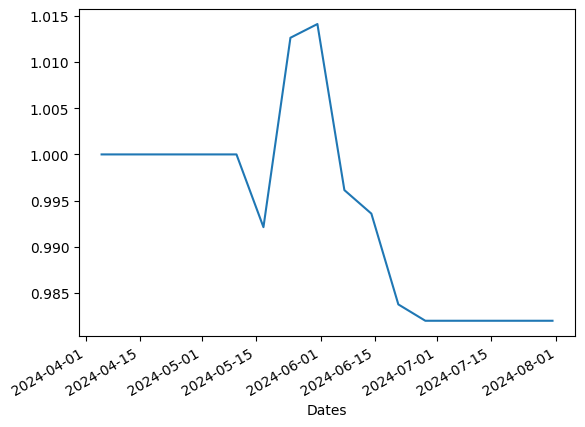

In [247]:
(1+ew_short_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

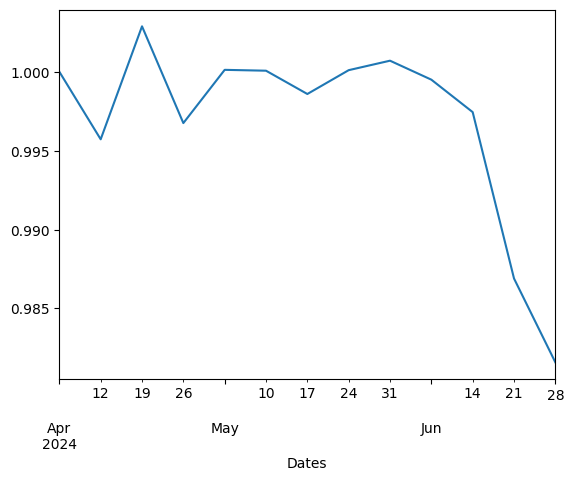

In [248]:
# remove top and bottom
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

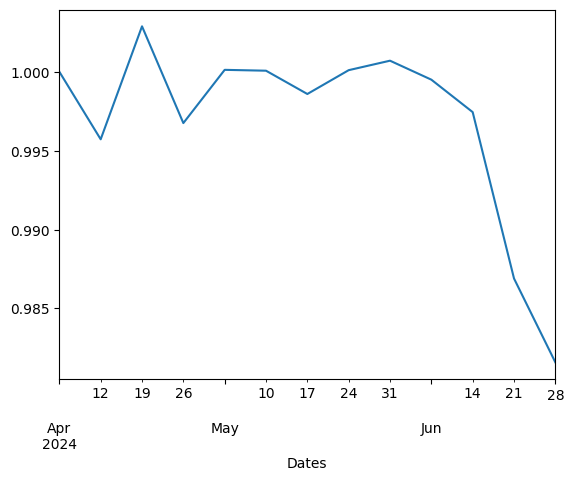

In [249]:
# remove in the middle
(1+idx_ret.sum(1)).cumprod().plot()

# optimize port

### how to optimize 
#### compare with market weight 
#### input: k200 weight, score, vol(return)


In [250]:
from scipy.optimize import minimize
import numpy as np

In [251]:
bmw=k200_df['idx_weight'].unstack()

In [252]:
adjprc.pct_change(60)

/tmp/ipykernel_309735/4222830641.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change(60)


Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A460860,A462520,A465770,A900030,A900050,A900140,A950010,A950070,A950100,A950210
Dates,,,,,,,,,,,,,,,,,,,,,
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,NaN,-0.062069,0.0,-0.397590,-0.060927,0.0,-0.015988,-0.038278,NaN,0.345070,...,-0.214539,0.087966,0.223529,NaN,0.0,-0.119782,0.0,NaN,0.0,0.517500
2024-07-26,NaN,-0.049143,0.0,-0.395897,-0.081152,0.0,-0.024496,-0.038005,NaN,0.312757,...,-0.234651,0.099515,0.371194,NaN,0.0,-0.114338,0.0,NaN,0.0,0.713574
2024-07-29,NaN,-0.041284,0.0,-0.419825,-0.070773,0.0,-0.021490,-0.004751,NaN,0.330110,...,-0.221658,0.112599,0.338095,NaN,0.0,-0.138298,0.0,NaN,0.0,0.640199


In [253]:
k200_df.index.get_level_values(0).unique()[k200_df.index.get_level_values(0).unique()>'2021-12-22']

DatetimeIndex(['2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-29', '2024-07-30', '2024-07-31',
               '2024-08-01', '2024-08-02'],
              dtype='datetime64[ns]', name='Dates', length=642, freq=None)

In [254]:
ls_w.index

DatetimeIndex(['2024-05-10', '2024-05-17', '2024-05-24', '2024-05-31',
               '2024-06-07', '2024-06-14', '2024-06-21', '2024-06-28',
               '2024-07-05', '2024-07-12', '2024-07-19', '2024-07-26',
               '2024-07-31'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [255]:
comm_dates=ls_w.index.intersection(k200_df.index.get_level_values(0).unique())
rebal_dates = proc.find_entire_rebalancing_dates(comm_dates)

lack of the beginning part of data  2024-04-30 00:00:00 2024-05-10 00:00:00
expected date is not in inner dates 2024-06-30 00:00:00
2024-06-30 00:00:00 2024-06-28 00:00:00


In [256]:
rebal_dates

DatetimeIndex(['2024-05-31', '2024-06-28', '2024-07-31'], dtype='datetime64[ns]', freq=None)

In [257]:
bmw

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A373220,A375500,A377300,A381970,A383220,A383800,A402340,A450080,A454910,A457190
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.46,0.03,NaN,0.1,0.12,0.39,0.28,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.45,0.03,NaN,0.1,0.11,0.40,0.29,0.01,0.11,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.45,0.03,NaN,0.1,0.11,0.39,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.45,0.03,NaN,0.1,0.11,0.40,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.44,0.03,NaN,0.1,0.11,0.39,0.29,0.02,0.11,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,NaN,NaN,NaN,NaN,0.05,0.46,0.08,NaN,0.09,0.05,...,0.92,0.08,0.06,NaN,0.07,NaN,0.63,0.14,0.11,0.06
2024-07-30,NaN,NaN,NaN,NaN,0.05,0.47,0.09,NaN,0.09,0.05,...,0.94,0.08,0.06,NaN,0.07,NaN,0.61,0.14,0.11,0.06
2024-07-31,NaN,NaN,NaN,NaN,0.05,0.45,0.09,NaN,0.10,0.05,...,0.90,0.07,0.06,NaN,0.07,NaN,0.64,0.13,0.11,0.06


In [258]:
ls_w.iloc[-1].describe()

count    200.000000
mean       0.000190
std        0.006278
min       -0.013726
25%       -0.003817
50%        0.000409
75%        0.004912
max        0.013726
Name: 2024-07-31 00:00:00, dtype: float64

In [259]:
import optuna

In [260]:
# study=optuna.create_study(direction='maximize')
# study.optimize(port_objective, n_trials=30)

In [261]:
# study.best_trials

In [262]:
data_COM_nodup.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [263]:
bmw.loc[rebal_dates[-1]]

Symbol
A000030     NaN
A000050     NaN
A000060     NaN
A000070     NaN
A000080    0.05
           ... 
A383800     NaN
A402340    0.64
A450080    0.13
A454910    0.11
A457190    0.06
Name: 2024-07-31 00:00:00, Length: 303, dtype: float64

In [264]:
pd.concat([data_COM_nodup.loc[rebal_dates[-1], 'FG_Sector_Idx'], bmw.loc[rebal_dates[-1]]], axis=1).groupby('FG_Sector_Idx').sum()

,2024-07-31 00:00:00
FG_Sector_Idx,
IT,48.93
경기소비재,9.57
금융,11.91
산업재,11.80
소재,5.94
에너지,2.00
유틸리티,0.67
의료,4.92
통신서비스,1.55


In [265]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

In [266]:
rebal_dates

DatetimeIndex(['2024-05-31', '2024-06-28', '2024-07-31'], dtype='datetime64[ns]', freq=None)

In [563]:
def score_objective(weight, bm_weight, score, cov):
    # weight=np.where(weight<10**-3, 0, np.maximum(x, 10**-3))
    w_diff=abs(weight-bm_weight)
    if w_diff.sum()==0:
        return 0
    try:
        # Check for specific error message before sqrt
        if np.any(np.isnan(np.dot(w_diff.T, np.dot(cov, w_diff)))):
            raise ValueError("Encountered NaN values during portfolio volatility calculation.")
        port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    
    except (ValueError, RuntimeWarning) as e:
        print(w_diff.isin([np.inf, -np.inf]).any().any())
        print(cov.isin([np.inf, -np.inf]).any().any())
        print(np.dot(cov, w_diff))
        print(np.dot(w_diff.T, np.dot(cov, w_diff)))
        print("Warning: Encountered errors during portfolio volatility calculation.")
        print(e)
    
    adj_sharpe=(w_diff*score).sum() / port_vol
    return -adj_sharpe


def handle_missingCol(port_df, bm_df):
    """
        compare given port column and BM column
    """
    missing_cols = set(bm_df.index) - set(port_df.index)

    if len(missing_cols)>0:
    # if method=='fill':
        
        # Add the missing columns to df1 with NaN values
        for col in missing_cols:
            print('missing col: ', col)
            # df1.loc[col] = pd.Series([None] * len(df1), index=df1.index)
            port_df.loc[col]=None
        # port_df=port_df.loc[bm_df.index]
        
    # elif len(bm_df.index) < len(port_df.index):
        # elif method=='drop':
        # comm_col=port_df.index.intersection(bm_df.index)
        # port_df=port_df.loc[comm_col]
    
    port_df=port_df.loc[bm_df.index]
        
    print(f"port shape: {port_df.shape}, bm shape: {bm_df.shape}, compare : {(port_df.index==bm_df.index).sum()}")
    return port_df


def convert_lsScore(port_score, short_num, long_num):
    """
        when score is all positive, it convert to the mean of score is 0 so that it can be used in Long/Short       
    """
    # convert into L/S scores
    sort_score=port_score.sort_values().dropna().copy()
    port_score[:]=np.nan # port_score.mean()
    if short_num>0:
        port_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]

    port_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]       
    # port_score=port_score.fillna(0)
    
    return port_score


def create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw):

    # sector constraints variables       
    sector_mapping = {sector: idx for idx, sector in enumerate(temp_bm_sectorw.index)}

    A = np.zeros((len(temp_bm_sectorw), len(temp_bm_stockw)), dtype=int)
    for i, stock in enumerate(temp_bm_stockw.index):
        sector_idx = sector_mapping[temp_bm_stockw.loc[temp_bm_stockw.index == stock, 'sector'].iloc[0]]
        A[sector_idx, i] = 1
    
    return A

def create_excludingMatrix(temp_port_score):
    # B = np.eye(len(temp_port_score))
    # B[temp_port_score.isnull()] = 0
    B = np.zeros(len(temp_port_score))
    
    # Set entries corresponding to non-selected stocks (e.g., those with NaN scores) to 0
    B[temp_port_score.isnull()] = 1
        
    return B


# def filter_stock_with_trend():
    

def optimize_portfolio_(raw_score, bm_weight, sector_info, rebal_dates, long_num, short_num, excess_stockw, excess_sectorw):
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        # slice BM weight
        temp_bm_weight=bm_weight.loc[rebal_date].dropna()
        
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
        print('bmw: ', temp_bm_weight.loc['A005930'])
        
        temp_raw_score=raw_score.loc[rebal_date].dropna()
        print('rawscore: ', temp_raw_score.loc['A005930'])
        
        # slice port weight
        temp_port_score=handle_missingCol(temp_raw_score, temp_bm_weight)
        # B=create_excludingMatrix(temp_port_score)
        print('bm adj score: ', temp_port_score.shape, temp_port_score.dropna().shape)
        temp_port_score=temp_port_score.fillna(0)

        # convert score into long/short score
        temp_score=convert_lsScore(temp_port_score, short_num, long_num)
        print('l/s num: ', temp_score.dropna().shape)
        
        B=create_excludingMatrix(temp_score)
        print(B.shape, B.sum())        

        # compute covariance
        temp_cov=adjprc.loc[:rebal_date, temp_score.index].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
               
        # load sector weight info
        # temp_bm_sector=data_COM_nodup.loc[rebal_date, 'FG_Sector_Idx']
        # temp_bm_sector=data_COM_nodup.loc[rebal_date, 'FG_Sector_Idx'].unstack().ffill().stack()

        # concat with bm stock weights include all stocks in BM 
        # to compute sector weights, all BM stocks required
        # excluding matrix so that it does not include not picked up stocks
        
        temp_bm_stockw=pd.concat([sector_info.loc[rebal_date].dropna(), temp_bm_weight], axis=1)
        temp_bm_stockw.columns=['sector', 'bm_weight']
        temp_bm_stockw=temp_bm_stockw.loc[temp_port_score.index]
        temp_bm_sectorw=temp_bm_stockw.groupby('sector').sum()
        print('bm sectorw: ', temp_bm_sectorw)
        
        A=create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw)
        
        # Define the constraints (weights sum to 1)
        const1 = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        # const11 = {'type': 'eq', 'fun': lambda x: np.sum(B*x).sum()}
        const2 = {'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight)+excess_stockw}
        const3 = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(A, x) - temp_bm_sectorw.values.flatten()) + excess_sectorw}
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(temp_score.index)))

        constraints=[const1, const2, const3] #+sec_ub+sec_lb

        # Initial guess (equal weights)
        initial_guess = [1 / len(temp_score.index) for asset in range(len(temp_score.index))]
        # initial_guess=np.dot(B, initial_guess)
        # initial_guess = temp_bm_weight.values
        
        # Perform the optimization
        print(temp_bm_weight.shape, temp_score.shape, temp_cov.shape)
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight, temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=constraints) # 
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=temp_score.index, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()

    # daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    # daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_optw


In [723]:
size_label=data_COM_nodup.loc[rebal_dates, 'KSECapSize']
size_label=size_label.unstack().ffill().stack()

In [450]:
sector_label=data_COM_nodup.loc[rebal_dates, 'FG_Sector_Idx']
sector_label=sector_label.unstack().ffill().stack()

In [451]:
long_num=75
short_num=30
stockw=.01
sectorw=.02

In [452]:
daily_optw=optimize_portfolio_(ls_w, bmw, sector_label, rebal_dates, long_num, short_num, stockw, sectorw)

2024-05-31 00:00:00
bmw:  0.29487692615569344
rawscore:  -0.013485700121135648
port shape: (200,), bm shape: (200,), compare : 200
bm adj score:  (200,) (200,)
l/s num:  (105,)
(200,) 95.0
bm sectorw:          bm_weight
sector           
IT       0.477486
경기소비재    0.105463
금융       0.116670
산업재      0.111767
소재       0.067741
에너지      0.021913
유틸리티     0.006704
의료       0.048229
통신서비스    0.015709
필수소비재    0.028317
(200,) (200,) (200, 200)
2024-06-28 00:00:00
bmw:  0.3019792083166733
rawscore:  -0.016757242488783533
missing col:  A066970
port shape: (200,), bm shape: (200,), compare : 200
bm adj score:  (200,) (199,)
l/s num:  (105,)
(200,) 95.0


/tmp/ipykernel_309735/1376669033.py:120: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  temp_cov=adjprc.loc[:rebal_date, temp_score.index].pct_change(20).dropna(how='all', axis=0).cov()


bm sectorw:          bm_weight
sector           
IT       0.497801
경기소비재    0.106557
금융       0.108357
산업재      0.112155
소재       0.065674
에너지      0.020292
유틸리티     0.006797
의료       0.041283
통신서비스    0.014594
필수소비재    0.026489
(200,) (200,) (200, 200)
2024-07-31 00:00:00
bmw:  0.3138941682504751
rawscore:  -0.01372626190780966
port shape: (200,), bm shape: (200,), compare : 200
bm adj score:  (200,) (200,)
l/s num:  (105,)
(200,) 95.0
bm sectorw:          bm_weight
sector           
IT       0.489447
경기소비재    0.095729
금융       0.119136
산업재      0.118035
소재       0.059418
에너지      0.020006
유틸리티     0.006702
의료       0.049215
통신서비스    0.015505
필수소비재    0.026808


/tmp/ipykernel_309735/1376669033.py:120: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  temp_cov=adjprc.loc[:rebal_date, temp_score.index].pct_change(20).dropna(how='all', axis=0).cov()


(200,) (200,) (200, 200)


In [453]:
bmw['A005930']

Dates
2016-06-02    21.89
2016-06-03    22.07
2016-06-07    22.09
2016-06-08    22.02
2016-06-09    22.05
              ...  
2024-07-29    30.51
2024-07-30    30.75
2024-07-31    31.38
2024-08-01    31.08
2024-08-02    31.02
Name: A005930, Length: 2008, dtype: float64

<Axes: xlabel='Dates'>

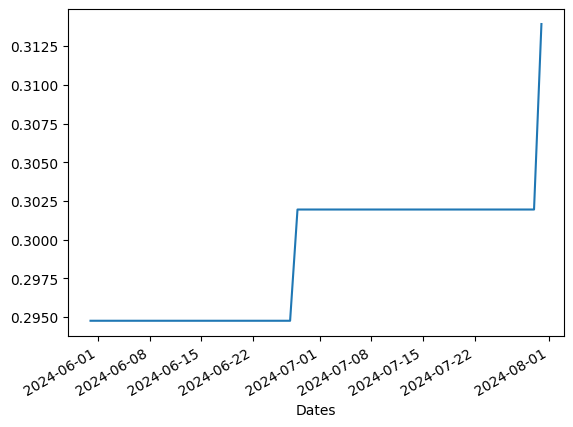

In [454]:
daily_optw['A005930'].plot()

In [455]:
check_stockw=[]
for rd in rebal_dates:
    check_stockw.append(daily_optw.loc[rd, 'A005930']*100-bmw.loc[rd, 'A005930'])

In [456]:
min(check_stockw), max(check_stockw)

(-0.015048148761461988, 0.012588035554507826)

In [457]:
sec_comp=[]
for rd in rebal_dates:
    port_sec=pd.concat([data_COM_nodup.loc[rd, 'FG_Sector_Idx'], daily_optw.loc[rd]], axis=1).groupby('FG_Sector_Idx').sum()*100
    bm_sec=pd.concat([data_COM_nodup.loc[rd, 'FG_Sector_Idx'], bmw.loc[rd]], axis=1).groupby('FG_Sector_Idx').sum()
    sec_comp.append(pd.concat([(port_sec-bm_sec).min(), (port_sec-bm_sec).idxmin(), (port_sec-bm_sec).max(), (port_sec-bm_sec).idxmax()], axis=1))

In [458]:
pd.concat(sec_comp, axis=0)

,0,1,2,3
2024-05-31,-1.363719,의료,1.171767,경기소비재
2024-06-28,-1.460000,통신서비스,1.004126,유틸리티
2024-07-31,-1.499358,소재,1.982940,경기소비재


<Axes: >

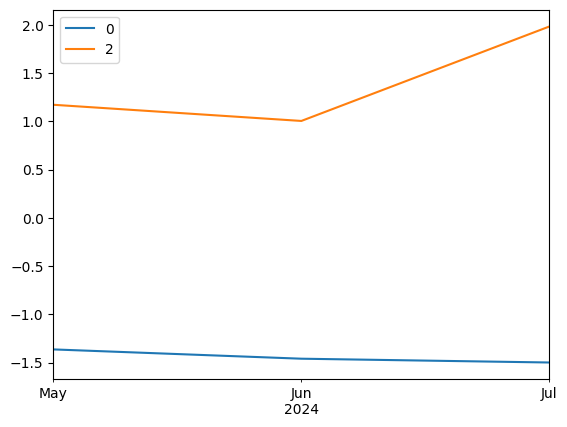

In [459]:
pd.concat(sec_comp, axis=0)[[0, 2]].plot()

<Axes: xlabel='Dates'>

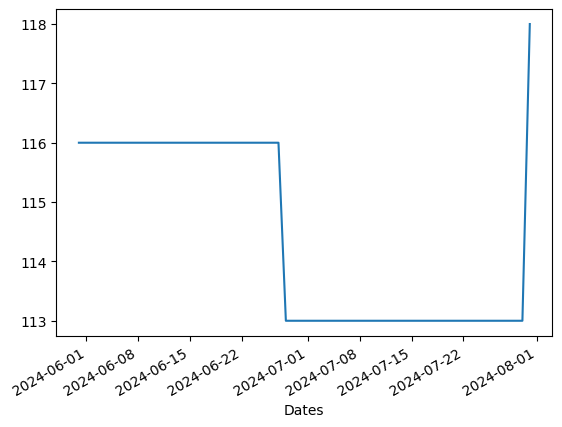

In [460]:
daily_optw[daily_optw>10**-3].count(1).plot()

In [461]:
daily_optw=daily_optw[daily_optw>10**-3]

In [462]:
daily_optw

Symbol,A000080,A000100,A000120,A000150,A000210,A000240,A000270,A000660,A000670,A000720,...,A377300,A383220,A402340,A450080,A003030,A005070,A042700,A066970,A454910,A457190
Dates,,,,,,,,,,,,,,,,,,,,,
2024-05-31,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-03,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-04,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-05,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-07,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-10,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-11,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-12,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-13,NaN,0.003520,NaN,0.001191,NaN,NaN,0.024907,0.082103,NaN,0.002097,...,0.001795,0.001348,0.006060,0.002460,NaN,NaN,NaN,NaN,NaN,NaN


In [463]:
daily_optw=daily_optw[~daily_optw.isna()].add((1-daily_optw.sum(1))/daily_optw.count(1), axis=0)

In [464]:
daily_optw[daily_optw>10**-3].sum(1)

Dates
2024-05-31    1.0
2024-06-03    1.0
2024-06-04    1.0
2024-06-05    1.0
2024-06-07    1.0
2024-06-10    1.0
2024-06-11    1.0
2024-06-12    1.0
2024-06-13    1.0
2024-06-14    1.0
2024-06-17    1.0
2024-06-18    1.0
2024-06-19    1.0
2024-06-20    1.0
2024-06-21    1.0
2024-06-24    1.0
2024-06-25    1.0
2024-06-26    1.0
2024-06-27    1.0
2024-06-28    1.0
2024-07-01    1.0
2024-07-02    1.0
2024-07-03    1.0
2024-07-04    1.0
2024-07-05    1.0
2024-07-08    1.0
2024-07-09    1.0
2024-07-10    1.0
2024-07-11    1.0
2024-07-12    1.0
2024-07-15    1.0
2024-07-16    1.0
2024-07-17    1.0
2024-07-18    1.0
2024-07-19    1.0
2024-07-22    1.0
2024-07-23    1.0
2024-07-24    1.0
2024-07-25    1.0
2024-07-26    1.0
2024-07-29    1.0
2024-07-30    1.0
2024-07-31    1.0
dtype: float64

In [465]:
daily_optw[daily_optw>10**-3].count(1)

Dates
2024-05-31    116
2024-06-03    116
2024-06-04    116
2024-06-05    116
2024-06-07    116
2024-06-10    116
2024-06-11    116
2024-06-12    116
2024-06-13    116
2024-06-14    116
2024-06-17    116
2024-06-18    116
2024-06-19    116
2024-06-20    116
2024-06-21    116
2024-06-24    116
2024-06-25    116
2024-06-26    116
2024-06-27    116
2024-06-28    113
2024-07-01    113
2024-07-02    113
2024-07-03    113
2024-07-04    113
2024-07-05    113
2024-07-08    113
2024-07-09    113
2024-07-10    113
2024-07-11    113
2024-07-12    113
2024-07-15    113
2024-07-16    113
2024-07-17    113
2024-07-18    113
2024-07-19    113
2024-07-22    113
2024-07-23    113
2024-07-24    113
2024-07-25    113
2024-07-26    113
2024-07-29    113
2024-07-30    113
2024-07-31    118
dtype: int64

In [296]:
daily_optw.to_csv(f"../data/output/weight/{period2}weight_stock{stockw}_constraint.csv")

In [466]:
daily_optw=daily_optw.replace(0.0, np.nan)

In [467]:
monthly_optw=daily_optw.loc[rebal_dates]

In [468]:
monthly_optw['A005930']

2024-05-31    0.295172
2024-06-28    0.302354
2024-07-31    0.314280
Name: A005930, dtype: float64

In [469]:
monthly_optw.index.duplicated().sum()

0

In [301]:
monthly_optw.to_csv(f"../data/output/weight/{period2}weight_stock{stockw}_monthly.csv")

In [470]:
monthly_optw.iloc[-1].dropna().sort_values()

Symbol
A139480    0.001357
A012750    0.001365
A352820    0.001367
A006360    0.001370
A272210    0.001381
             ...   
A068270    0.023893
A105560    0.024314
A005380    0.027659
A000660    0.086857
A005930    0.314280
Name: 2024-07-31 00:00:00, Length: 118, dtype: float64

In [471]:
compare_bmw=bmw.loc['2024-07-31', monthly_optw.iloc[-1].dropna().index].sort_values(ascending=False)

In [472]:
compare_bmw=compare_bmw/100

In [473]:
weight_diff=monthly_optw.iloc[-1].dropna()-compare_bmw

In [474]:
weight_diff.sort_values(ascending=False)

Symbol
A111770    0.010097
A271560    0.009814
A036570    0.008929
A383220    0.007248
A051900    0.006854
             ...   
A003550   -0.003274
A373220   -0.007267
A005490   -0.007527
A035420   -0.009641
A051910   -0.009643
Name: 2024-07-31 00:00:00, Length: 118, dtype: float64

In [475]:
from scipy import stats

In [711]:
"""
    exclude:
    long_term: neg & mid_term: neg & short_term: neg
    long_term: pos & short_term: neg
    
    
"""

long_term=252
mid_term=60
short_term=20
filtered_stocks=[]

for symbol in weight_diff.index:
    long_x=np.arange(long_term)
    long_y=adjprc.iloc[-long_term:][symbol]
    long_slope, _, long_rvalue, long_pvalue, long_std_err=stats.linregress(long_x, long_y)
    
    mid_x=np.arange(mid_term)
    mid_y=adjprc.iloc[-mid_term:][symbol]
    mid_slope, _, mid_rvalue, mid_pvalue, mid_std_err=stats.linregress(mid_x, mid_y)

    short_x=np.arange(short_term)
    short_y=adjprc.iloc[-short_term:][symbol]
    short_slope, _, short_rvalue, short_pvalue, short_std_err=stats.linregress(short_x, short_y)

    
    if long_slope <0 and mid_slope <0:
        filtered_stocks.append({
                                'symbol': symbol,
                                'long_slope': np.round(long_slope, 3),
                                'long_rvalue': np.round(long_rvalue, 3),
                                'long_pvalue': np.round(long_pvalue, 3),
                                'mid_slope': np.round(mid_slope, 3),
                                'mid_rvalue': np.round(mid_rvalue, 3),
                                'mid_pvalue': np.round(mid_pvalue, 3),
                                'short_slope': np.round(short_slope, 3),
                                'short_rvalue': np.round(short_rvalue, 3),
                                'short_pvalue': np.round(short_pvalue, 3)
                                })
        
    elif long_slope >0 and short_slope <0:
        filtered_stocks.append({
                                'symbol': symbol,
                                'long_slope': np.round(long_slope, 3),
                                'long_rvalue': np.round(long_rvalue, 3),
                                'long_pvalue': np.round(long_pvalue, 3),
                                'mid_slope': np.round(mid_slope, 3),
                                'mid_rvalue': np.round(mid_rvalue, 3),
                                'mid_pvalue': np.round(mid_pvalue, 3),
                                'short_slope': np.round(short_slope, 3),
                                'short_rvalue': np.round(short_rvalue, 3),
                                'short_pvalue': np.round(short_pvalue, 3)
                                })
                               

In [712]:
filtered_stocks

[{'symbol': 'A000150',
  'long_slope': 499.334,
  'long_rvalue': 0.767,
  'long_pvalue': 0.0,
  'mid_slope': 521.353,
  'mid_rvalue': 0.379,
  'mid_pvalue': 0.003,
  'short_slope': -4042.406,
  'short_rvalue': -0.885,
  'short_pvalue': 0.0},
 {'symbol': 'A000270',
  'long_slope': 226.494,
  'long_rvalue': 0.901,
  'long_pvalue': 0.0,
  'mid_slope': 47.847,
  'mid_rvalue': 0.148,
  'mid_pvalue': 0.258,
  'short_slope': -720.451,
  'short_rvalue': -0.934,
  'short_pvalue': 0.0},
 {'symbol': 'A000660',
  'long_slope': 475.233,
  'long_rvalue': 0.93,
  'long_pvalue': 0.0,
  'mid_slope': 568.541,
  'mid_rvalue': 0.498,
  'mid_pvalue': 0.0,
  'short_slope': -2917.218,
  'short_rvalue': -0.928,
  'short_pvalue': 0.0},
 {'symbol': 'A000720',
  'long_slope': -16.199,
  'long_rvalue': -0.75,
  'long_pvalue': 0.0,
  'mid_slope': -42.363,
  'mid_rvalue': -0.673,
  'mid_pvalue': 0.0,
  'short_slope': 62.256,
  'short_rvalue': 0.524,
  'short_pvalue': 0.018},
 {'symbol': 'A000810',
  'long_slope': 5

In [713]:
filered_df=pd.DataFrame(filtered_stocks).sort_values(by='long_slope')

In [714]:
len(filered_df['symbol'])

66

In [715]:
filtered_stocks=list(set(weight_diff[weight_diff>.001].index).intersection(set(filered_df['symbol'])))

In [716]:
filtered_stocks

['A004170',
 'A069960',
 'A018880',
 'A051900',
 'A009970',
 'A008770',
 'A271560',
 'A036570',
 'A383220',
 'A003030',
 'A302440',
 'A377300',
 'A004000']

In [691]:
eqw=bmw.loc['2024-07-31', filered_df['symbol'].values]

In [692]:
eqw

Symbol
A051910    1.11
A006400    1.31
A005490    1.89
A373220    0.90
A003670    0.45
           ... 
A000150    0.10
A000810    0.92
A010120    0.23
A042700    0.44
A267260    0.51
Name: 2024-07-31 00:00:00, Length: 66, dtype: float64

In [693]:
final_port=monthly_optw.iloc[-1].copy()

In [694]:
final_port.sum()

1.0

In [695]:
final_port.loc[filtered_stocks]=eqw/100

In [696]:
final_port.dropna()

Symbol
A000100    0.004935
A000150    0.001386
A000270    0.022278
A000660    0.086857
A000720    0.002264
             ...   
A003030    0.000200
A005070    0.002710
A042700    0.004778
A066970    0.002501
A454910    0.001463
Name: 2024-07-31 00:00:00, Length: 118, dtype: float64

In [697]:
weight_diff2=final_port.dropna()-compare_bmw

In [698]:
weight_diff2.min()

-0.009642739380477881

In [699]:
weight_diff2=weight_diff2+abs(weight_diff2.min())

In [700]:
weight_diff2.min()

0.0

In [701]:
additional_weights=weight_diff2/weight_diff2.sum() * (1-final_port.sum())

In [702]:
final_port_adj=final_port+additional_weights

In [703]:
additional_weights.sort_values()

Symbol
A051910    0.000000e+00
A035420    1.115738e-07
A005490    1.077365e-04
A373220    1.210043e-04
A003550    3.243868e-04
               ...     
A081660    5.254396e-04
A002710    5.372221e-04
A078930    5.567544e-04
A001800    7.532730e-04
A111770    1.005397e-03
Name: 2024-07-31 00:00:00, Length: 118, dtype: float64

In [704]:
final_port_adj.dropna().sort_values()

Symbol
A003030    0.000691
A009970    0.000791
A069960    0.000991
A004000    0.000991
A377300    0.001091
             ...   
A068270    0.024400
A105560    0.024826
A005380    0.028168
A000660    0.087367
A005930    0.314795
Name: 2024-07-31 00:00:00, Length: 118, dtype: float64

In [684]:
final_port_adj.to_csv(f"../data/output/weight/{period2}_screened_weight_stock{stockw}_port2.csv")

In [705]:
(final_port_adj-compare_bmw).dropna().sort_values()

Symbol
A051910   -0.009643
A035420   -0.009640
A005490   -0.007420
A373220   -0.007146
A003550   -0.002949
             ...   
A081660    0.001199
A002710    0.001442
A078930    0.001845
A001800    0.005900
A111770    0.011103
Name: 2024-07-31 00:00:00, Length: 118, dtype: float64

In [663]:
(final_port_adj-compare_bmw).dropna().sort_values().to_csv(f"../data/output/weight/{period2}_screened_weightdiff_stock{stockw}_port.csv")

In [745]:
def score_objective(weight, score, cov):
    weight_adj=np.where(weight<10**-3, 0, np.maximum(weight, 10**-3))
    # w_diff=abs(weight_adj-bm_weight)
    # if w_diff.sum()==0:
    #     return 0
    try:
        # Check for specific error message before sqrt
        if np.any(np.isnan(np.dot(weight_adj.T, np.dot(cov, weight_adj)))):
            raise ValueError("Encountered NaN values during portfolio volatility calculation.")
        port_vol = np.sqrt(np.dot(weight_adj.T, np.dot(cov, weight_adj)))
    
    except (ValueError, RuntimeWarning) as e:
        print(w_diff.isin([np.inf, -np.inf]).any().any())
        print(cov.isin([np.inf, -np.inf]).any().any())
        print(np.dot(cov, weight_adj))
        print(np.dot(weight_adj.T, np.dot(cov, weight_adj)))
        print("Warning: Encountered errors during portfolio volatility calculation.")
        print(e)
    
    adj_sharpe= score.sum() / port_vol
    return -adj_sharpe


def convert_lsScore(port_score, short_num, long_num):
    """
        when score is all positive, it convert to the mean of score is 0 so that it can be used in Long/Short       
    """
    # convert into L/S scores
    sort_score=port_score.sort_values().dropna().copy()
    port_score[:]=np.nan # port_score.mean()
    if short_num>0:
        port_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]

    port_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]       
    # port_score=port_score.fillna(0)
    
    return port_score


def optimize_portfolio3_(port_weight, bm_weight, adj_prc, 
                         sector_info, size_info, 
                         excess_stockw, excess_sectorw, excess_sizew,
                         long_num, short_num):    
    # slice BM weight   
    temp_bm_weight=bm_weight/bm_weight.sum()
    print('bmw: ', temp_bm_weight.loc['A005930'])
    
    temp_raw_port=port_weight.dropna()
    print('rawscore: ', temp_raw_port.loc['A005930'])
    
    # slice port weight
    temp_port=handle_missingCol(temp_raw_port, temp_bm_weight)
    print('bm adj score: ', temp_port.shape, temp_port.dropna().shape)
    temp_port=temp_port.fillna(0)
    
    temp_score=convert_lsScore(temp_port, short_num, long_num)

    # convert score into long/short score
    print('l/s num: ', temp_score.dropna().shape)
    B=create_excludingMatrix(temp_score)
    print(B.shape, B.sum())        

    # compute covariance
    temp_cov=adjprc[temp_score.index].pct_change(20).dropna(how='all', axis=0).cov()
    temp_cov=temp_cov.fillna(0)

    """
     concat with bm stock weights include all stocks in BM 
     to compute sector weights, all BM stocks required
     excluding matrix so that it does not include not picked up stocks
    """
    
    temp_bm_stockw=pd.concat([sector_info.dropna(), size_info.dropna(), temp_bm_weight], axis=1)
    temp_bm_stockw.columns=['sector', 'size', 'bm_weight']
    temp_bm_stockw=temp_bm_stockw.loc[temp_port.index]
    print(temp_bm_stockw['sector'])
    temp_bm_sectorw=temp_bm_stockw[['sector', 'bm_weight']].groupby('sector').sum()
    temp_bm_sizew=temp_bm_stockw[['size', 'bm_weight']].groupby('size').sum()

    
    print('bm sectorw: ', temp_bm_sectorw)
    
    A=create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw)
    
    # Define the constraints (weights sum to 1)
    const1 = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    # const11 = {'type': 'eq', 'fun': lambda x: np.sum(B*x).sum()}
    const2 = {'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight)+excess_stockw}
    const3 = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(A, x) - temp_bm_sectorw.values.flatten()) + excess_sectorw}
    const4 = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(A, x) - temp_bm_sizew.values.flatten()) + excess_sizew}
    
    # Define the bounds (each weight is between 0 and 1)
    bounds = tuple((0, 1) for asset in range(len(temp_port.index)))

    constraints=[const1, const2, const3] #+sec_ub+sec_lb

    # Initial guess (equal weights)
    initial_guess = [1 / len(temp_score.index) for asset in range(len(temp_port.index))]
    # initial_guess=np.dot(B, initial_guess)
    # initial_guess = temp_bm_weight.values
    
    # Perform the optimization
    print(temp_bm_weight.shape, temp_score.shape, temp_cov.shape)
    result = minimize(score_objective, initial_guess, args=(temp_score, temp_cov),
                      method='SLSQP', bounds=bounds, constraints=constraints) # 
        
    # Extract the optimized weights
    optimal_weights = result.x
    optw_df=pd.DataFrame(optimal_weights, index=temp_port.index)
    
    return optw_df


In [746]:
stockw=.015
sectorw=.04
sizew=.05
long_num=75
short_num=30
final_port_opt=optimize_portfolio3_(final_port, 
                                    bmw.loc[period2].dropna(), 
                                    adjprc.loc[period1:period2],
                                    sector_label.loc[period2],
                                    size_label.loc[period2],
                                    stockw, 
                                    sectorw,
                                    sizew,
                                    long_num,
                                    short_num)

bmw:  0.3138941682504751
rawscore:  0.31427980997554883
missing col:  A009900
missing col:  A006650
missing col:  A285130
missing col:  A008930
missing col:  A008730
missing col:  A001450
missing col:  A336260
missing col:  A009240
missing col:  A282330
missing col:  A004370
missing col:  A030000
missing col:  A028670
missing col:  A042670
missing col:  A103140
missing col:  A000120
missing col:  A298020
missing col:  A178920
missing col:  A003090
missing col:  A457190
missing col:  A014820
missing col:  A114090
missing col:  A005420
missing col:  A004990
missing col:  A137310
missing col:  A007310
missing col:  A161390
missing col:  A001740
missing col:  A026960
missing col:  A023530
missing col:  A000670
missing col:  A093370
missing col:  A001680
missing col:  A361610
missing col:  A011210
missing col:  A005300
missing col:  A073240
missing col:  A120110
missing col:  A298050
missing col:  A005850
missing col:  A005250
missing col:  A047040
missing col:  A001120
missing col:  A08835

/tmp/ipykernel_309735/3775375641.py:45: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  temp_cov=adjprc[temp_port.index].pct_change(20).dropna(how='all', axis=0).cov()


Symbol
A000080    필수소비재
A000100       의료
A000120      산업재
A000150      산업재
A000210       소재
           ...  
A383220    경기소비재
A402340      산업재
A450080       IT
A454910      산업재
A457190       소재
Name: sector, Length: 200, dtype: object
bm sectorw:          bm_weight
sector           
IT       0.489447
경기소비재    0.095729
금융       0.119136
산업재      0.118035
소재       0.059418
에너지      0.020006
유틸리티     0.006702
의료       0.049215
통신서비스    0.015505
필수소비재    0.026808
(200,) (200,) (200, 200)


0.01

In [618]:
final_port_opt=final_port_opt.sort_values(0, ascending=False)
final_port_opt

,0
Symbol,
A005930,0.303467
A000660,0.076424
A005380,0.027322
A068270,0.024160
A000270,0.021747
...,...
A035250,0.000032
A078930,0.000032
A011170,0.000032


In [619]:
final_port_opt[final_port_opt>10**-3].sum(), final_port_opt.sum()

(0    0.965472
 dtype: float64,
 0    1.000321
 dtype: float64)

In [620]:
final_port_opt[final_port_opt>10**-3].dropna()

,0
Symbol,
A005930,0.303467
A000660,0.076424
A005380,0.027322
A068270,0.024160
A000270,0.021747
...,...
A192820,0.001002
A006360,0.001001
A377300,0.001000


In [104]:
monthly_optw.index.get_level_values(0).unique()

DatetimeIndex(['2024-04-26', '2024-05-31', '2024-06-28'], dtype='datetime64[ns]', freq=None)

In [105]:
daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw

/tmp/ipykernel_309735/3117912796.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw


In [106]:
daily_optret.sum(1)

Dates
2024-04-26    0.012739
2024-04-29    0.010157
2024-04-30    0.001794
2024-05-02   -0.001354
2024-05-03   -0.001113
2024-05-07    0.023836
2024-05-08    0.003103
2024-05-09   -0.014008
2024-05-10    0.006035
2024-05-13   -0.000808
2024-05-14   -0.000128
2024-05-16    0.009045
2024-05-17   -0.011717
2024-05-20    0.007621
2024-05-21   -0.006265
2024-05-22   -0.003469
2024-05-23    0.001401
2024-05-24   -0.014677
2024-05-27    0.014953
2024-05-28    0.002146
2024-05-29   -0.017199
2024-05-30   -0.017543
2024-05-31   -0.000797
2024-06-03    0.019993
2024-06-04   -0.009059
2024-06-05    0.009815
2024-06-07    0.015414
2024-06-10   -0.010281
2024-06-11    0.001014
2024-06-12    0.008869
2024-06-13    0.009436
2024-06-14    0.005409
2024-06-17   -0.005786
2024-06-18    0.008910
2024-06-19    0.014910
2024-06-20    0.005056
2024-06-21   -0.003132
2024-06-24   -0.008894
2024-06-25    0.002714
2024-06-26    0.007364
2024-06-27   -0.000841
2024-06-28    0.004855
dtype: float64

In [107]:
daily_opt_cumret=(1+daily_optret.sum(1)).cumprod()

In [108]:
daily_opt_cumret

Dates
2024-04-26    1.012739
2024-04-29    1.023026
2024-04-30    1.024861
2024-05-02    1.023473
2024-05-03    1.022334
2024-05-07    1.046703
2024-05-08    1.049951
2024-05-09    1.035244
2024-05-10    1.041492
2024-05-13    1.040651
2024-05-14    1.040517
2024-05-16    1.049928
2024-05-17    1.037626
2024-05-20    1.045533
2024-05-21    1.038983
2024-05-22    1.035379
2024-05-23    1.036829
2024-05-24    1.021611
2024-05-27    1.036887
2024-05-28    1.039112
2024-05-29    1.021240
2024-05-30    1.003324
2024-05-31    1.002524
2024-06-03    1.022567
2024-06-04    1.013304
2024-06-05    1.023250
2024-06-07    1.039022
2024-06-10    1.028340
2024-06-11    1.029383
2024-06-12    1.038513
2024-06-13    1.048312
2024-06-14    1.053982
2024-06-17    1.047884
2024-06-18    1.057221
2024-06-19    1.072984
2024-06-20    1.078410
2024-06-21    1.075032
2024-06-24    1.065471
2024-06-25    1.068362
2024-06-26    1.076229
2024-06-27    1.075324
2024-06-28    1.080544
dtype: float64

In [109]:
excess_ret=(daily_optret.sum(1)-krx_idx['코스피 200'].pct_change().loc[daily_optw.index])

In [110]:
samsung_excess_ret=adjprc.loc[daily_optw.index, 'A005930'].pct_change()-krx_idx['코스피 200'].pct_change().loc[daily_optw.index]

<Axes: xlabel='Dates'>

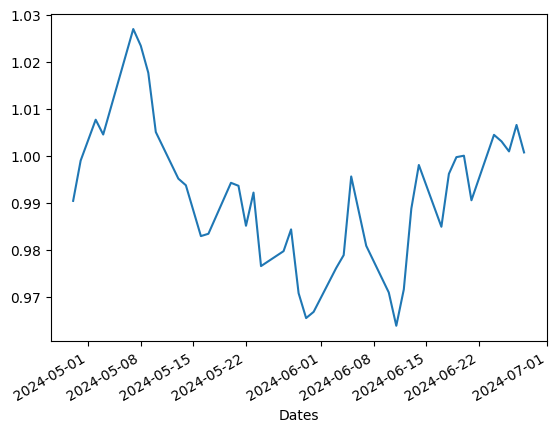

In [111]:
(1+samsung_excess_ret).cumprod().plot()

<Axes: xlabel='Dates'>

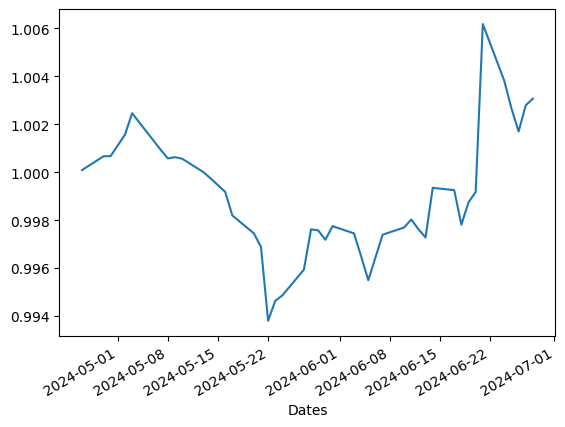

In [112]:
(1+excess_ret).cumprod().plot()

<Axes: xlabel='Dates'>

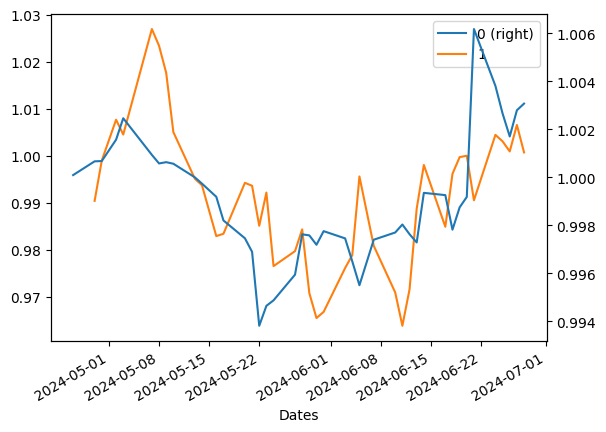

In [113]:
pd.concat([(1+excess_ret).cumprod(), (1+samsung_excess_ret).cumprod()], axis=1).plot(secondary_y=0)

In [271]:
bm_cumret=(1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()

<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

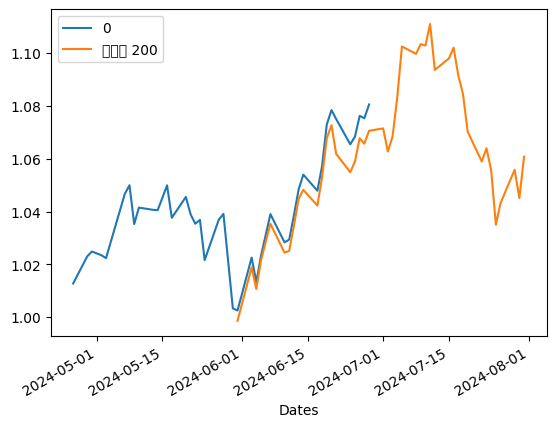

In [272]:
pd.concat([daily_opt_cumret, bm_cumret], axis=1).plot()

In [ ]:
# 70
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[daily_optw.index, 
                                                                        daily_optw.columns], 
                                                                        daily_optw,
                                                                        cost=0.002)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()], axis=1).plot()

In [ ]:
a

In [ ]:
daily_optw.iloc[-1].sort_values(ascending=False).loc[['A005930', 'A000660']]

In [ ]:
adjprc.loc['2023-12-25':'2024-01-02'].index

In [ ]:
recent_date='2023-12-28'
recentw=pd.DataFrame(None, index=adjprc.loc[recent_date:].index, columns=daily_optw.columns)

In [ ]:
recentw.loc[recent_date]=daily_optw.iloc[-1]

In [ ]:
recentw=recentw.ffill()

In [ ]:
recent_ret=recentw*adjprc.pct_change().loc[recentw.index, recentw.columns]

In [ ]:
(1+pd.concat([recent_ret.sum(1), krx_idx['코스피 200'].pct_change().loc[recent_date:]], axis=1)).cumprod().plot()

In [ ]:
optw_df.sort_values('opt_w')

In [ ]:
(optw_df['opt_w']-temp_bm_weight).sort_values()

In [ ]:
temp_bm_weight.sort_values()

# sector neutral


### 1. (use selection only) use top score stocks only then allocate weight proportion to the actual market cap
####  if no stock is selected in a sector then follow BM 

### 2. (use selection and score) set boundary of tilt amount and do optimization using score

### 3. (use BM and score) use entire index and tilting using optimization

In [ ]:
data_SSC_nodup.columns

In [ ]:
data_COM_nodup.columns

In [ ]:
temp_com=data_COM_nodup[['KSECapSize', 'FG_Sector_Idx', 'KOSPI200YN']].copy()

In [ ]:
temp_ssc=data_SSC_nodup[['MktCap']].copy()

In [ ]:
bm_mktcap=pd.concat([temp_com, temp_ssc], axis=1)

In [ ]:
bm_mktcap

In [ ]:
bm_mktcap=bm_mktcap[bm_mktcap['KOSPI200YN']=='Y']

In [ ]:
bm_mktcap['MktCap']=bm_mktcap['MktCap'].astype(float)


In [ ]:
bm_mktcap

In [ ]:
bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum('MktCap')

In [ ]:
# bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()

In [ ]:

bm_sector_weight=bm_sector_cap /bm_mktcap.groupby(['Dates']).sum('MKtCap')

In [ ]:
# temp_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')/daily_sector_weight.groupby(['Dates']).sum()

In [ ]:
bm_sector=bm_mktcap['FG_Sector_Idx'].copy()
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'FG_Sector_Idx'], inplace=True)
bm_sector=pd.concat([bm_sector, bm_sector_weight], axis=1)
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'Symbol'], inplace=True)

In [ ]:
# daily_sector_weight=temp_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()/temp_mktcap.groupby(['Dates']).sum()

In [ ]:
# daily_sector_weight=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')
# daily_sector_weight=daily_sector_weight/daily_sector_weight.groupby(['Dates']).sum()

## stock selection from k200

In [ ]:
num_selection=75
top_prob_ls = []

for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob=raw_prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection]
    tempw = scaler.fit_transform(top_prob.values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = top_prob.index)
    top_prob_ls.append(temp_w)
    
top_prob_df=pd.concat(top_prob_ls, axis=1)
top_prob_df=top_prob_df.T
top_prob_df.index=raw_prob.index

top_prob_df=top_prob_df.stack().to_frame()
top_prob_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

In [ ]:
cap_prob_df.dropna()

## stock selection from k100

In [ ]:
top_prob_k100_ls = []

k100prob=raw_prob * k100comp.loc[raw_prob.index]

num_selection_k100=50
for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob_k100=k100prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection_k100]
    tempw_k100 = scaler.fit_transform(top_prob_k100.values.reshape(-1, 1))
    tempw_k100 = pd.DataFrame(tempw_k100, index = top_prob_k100.index)
    top_prob_k100_ls.append(tempw_k100)
    
top_prob_k100_df=pd.concat(top_prob_k100_ls, axis=1)
top_prob_k100_df=top_prob_k100_df.T
top_prob_k100_df.index=raw_prob.index

top_prob_k100_df=top_prob_k100_df.stack().to_frame()
top_prob_k100_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_k100_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_k100_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_k100_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

## rebal dates

In [ ]:
sector_dates=cap_prob_df.dropna().index.get_level_values(0).unique()
sector_dates=pd.to_datetime(sector_dates)
sector_dates=sector_dates.sort_values()

rebal_dates = proc.find_entire_rebalancing_dates(sector_dates)
rebal_dates

In [ ]:
sector_ls=list(bm_sector['FG_Sector_Idx'].unique())
sector='IT'
given_samsung_weight=.3
sam_w=k200_df[k200_df.index.get_level_values(1)=='A005930']

## sector neutral port with samsung neutral

In [ ]:
weight_ls=[]
for date in rebal_dates:
    print(date)
    temp_sector_cap_prob=cap_prob_df[cap_prob_df.index.get_level_values(0)==date]
    
    sector_weight_ls=[]
    for sector in sector_ls:
        
        # when there is no stock in certain sector then keep all stocks in that missing sector
        if sector not in temp_sector_cap_prob.dropna()['FG_Sector_Idx'].unique():
            print(sector)
            temp_sector_neutral=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]['idx_weight']/100
            sector_weight_ls.append(temp_sector_neutral)
            
        else:
            temp_sector_tilt=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector].dropna()
            # temp_sector_neutral['sector_ew']=1/len(temp_sector_neutral)

            if sector=='IT':
                it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
                it_mktcap=temp_sector_tilt['MktCap'].drop(index='A005930', level='Symbol')
                it_mktcap_ratio=it_mktcap/it_mktcap.sum()*it_leftover
                it_mktcap_ratio.loc[(date, 'A005930')]=given_samsung_weight
                sector_weight_ls.append(it_mktcap_ratio)
            else:
                temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
                sector_weight_ls.append(temp_mktcap_ratio)

    weight_df=pd.concat(sector_weight_ls, axis=0)
    weight_ls.append(weight_df)

In [ ]:
temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]

## smoothing weights

In [ ]:
sector_neutral_weight=pd.concat(weight_ls).unstack().dropna(how='all', axis=0)
sector_neutral_weight=sector_neutral_weight.div(sector_neutral_weight.sum(1), axis=0)

temp_adj=adjprc.loc[sector_neutral_weight.index[0]:sector_neutral_weight.index[-1], sector_neutral_weight.columns].copy()
daily_w=temp_adj.copy()
daily_w.loc[sector_neutral_weight.index]=0
daily_w[daily_w!=0]=None
daily_w.loc[sector_neutral_weight.index]=sector_neutral_weight.fillna(0)
daily_w=daily_w.fillna(method='ffill')

In [ ]:
daily_w.sum(1).plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(temp_adj, 
                                                                        daily_w.shift(1),
                                                                        cost=0.003)

In [ ]:
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_w.index]).cumprod()], axis=1).plot()

## k200 ew port with samsung neutral

In [ ]:
top_prob_unstack=top_prob_df.unstack().copy()
top_prob_unstack.columns=top_prob_unstack.columns.get_level_values(1)

k200_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/75
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/76
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k200_weight_ls.append(temp_top_prob)

# k200 market weight

In [ ]:
temp_top_prob_df=top_prob_df[top_prob_df.index.get_level_values(0).isin(rebal_dates)]

In [ ]:
k200_df.index.get_level_values(0).unique(), top_prob_df.index.get_level_values(0).unique()

In [ ]:
temp_k200_df=k200_df[k200_df.index.isin(temp_top_prob_df.index)]

In [ ]:
temp_k200_df=temp_k200_df['idx_weight'].unstack()

In [ ]:
k200_df_mask=temp_k200_df.copy()
k200_df_mask[k200_df_mask>0]=1

In [ ]:
k200_df_mask

In [ ]:
temp_samw=sam_w[sam_w.index.get_level_values(0).isin(temp_k200_df.index.get_level_values(0))]['idx_weight']
temp_samw.index=temp_samw.index.get_level_values(0)

In [ ]:
temp_k200_df['A005930']=temp_samw

In [ ]:
k200_df_mask.sum(1)

In [ ]:
extra_weight=(100-temp_k200_df.sum(1))/k200_df_mask.sum(1)

In [ ]:
temp_k200_df

In [ ]:
k200_mask_weight=k200_df_mask.multiply(extra_weight, axis=0)

In [ ]:
k200_df_mkw=(k200_mask_weight.fillna(0) + temp_k200_df)

In [ ]:
def convert_rebal_to_daily(rebal_weight, daily_df):   
    daily_w=daily_df.loc[rebal_weight.index[0]:rebal_weight.index[-1], rebal_weight.columns].copy()
    daily_w.loc[rebal_weight.index]=0
    daily_w[daily_w!=0]=None
    daily_w.loc[rebal_weight.index]=rebal_weight.fillna(0)
    daily_w=daily_w.fillna(method='ffill')    
    return daily_w

In [ ]:
k200_weight_df=pd.concat(k200_weight_ls, axis=1).T
# temp_adj=adjprc.loc[k200_weight_df.index[0]:k200_weight_df.index[-1], k200_weight_df.columns].copy()
# k200_daily_w=temp_adj.copy()
# k200_daily_w.loc[k200_weight_df.index]=0
# k200_daily_w[k200_daily_w!=0]=None
# k200_daily_w.loc[k200_weight_df.index]=k200_weight_df.fillna(0)
# k200_daily_w=k200_daily_w.fillna(method='ffill')

In [ ]:
k200_daily_w=convert_rebal_to_daily(k200_weight_df, adjprc)
k200_daily_mkw=convert_rebal_to_daily(k200_df_mkw/100, adjprc)

In [ ]:
k200_daily_w.sum(1).plot()

In [ ]:
k200_daily_mkw.sum(1).plot()

In [ ]:
k200_daily_w.columns

In [ ]:
k200_daily_w['A005930'].plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_w.index, k200_daily_w.columns], 
                                                                        k200_daily_w.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index])

temp_perf200.T

In [ ]:
k200_daily_mkw

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_mkw.index, 
                                                                                    k200_daily_mkw.columns], 
                                                                        k200_daily_mkw.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index])

temp_perf200.T

## k100 ew with samsung neutral

In [ ]:
top_prob_k100_unstack=top_prob_k100_df.unstack().copy()
top_prob_k100_unstack.columns=top_prob_k100_unstack.columns.get_level_values(1)

k100_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_k100_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/num_selection_k100
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/(num_selection_k100+1)
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k100_weight_ls.append(temp_top_prob)    
        

In [ ]:
k100_weight_df=pd.concat(k100_weight_ls, axis=1).T
temp_adj=adjprc.loc[k100_weight_df.index[0]:k100_weight_df.index[-1], k100_weight_df.columns].copy()
k100_daily_w=temp_adj.copy()
k100_daily_w.loc[k100_weight_df.index]=0
k100_daily_w[k100_daily_w!=0]=None
k100_daily_w.loc[k100_weight_df.index]=k100_weight_df.fillna(0)
k100_daily_w=k100_daily_w.fillna(method='ffill')

In [ ]:
k100_weight_df.count(1)

In [ ]:
k100_ret, k100_ret_cost, k100_cum_ret, k100_cum_retcost = perf.return_index(temp_adj, 
                                                                        k100_daily_w.shift(1),
                                                                        cost=0.003)

### 75 ew/ 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf75 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_75',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])



In [ ]:
temp_perf75.T

### 50 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf50 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_50',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf50

### 100 ew /100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf100 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_100',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])
temp_perf100

### 30 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf30 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_30',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf30

In [ ]:
pd.concat([temp_perf30, temp_perf50, temp_perf75, temp_perf100], axis=0).T

In [ ]:
sector in temp_sector_cap_prob['FG_Sector_Idx'].unique()

In [ ]:
temp_bm_sector=bm_sector.loc[date]
temp_bm_sector[temp_bm_sector['FG_Sector_Idx']==sector]

In [ ]:
temp_bm_sector.index

In [ ]:
missing_sector=temp_mktcap[temp_mktcap['FG_Sector_Idx']==sector].loc[date, 'MktCap']
missing_sector/missing_sector.sum()

In [ ]:
temp_mktcap.loc[date][temp_bm_sector.index]

In [ ]:
temp_bm_sector.index

In [ ]:
daily_sector_weight

In [ ]:
temp_sector_neutral

In [ ]:
cap_prob_df.index.get_level_values(0).unique()

In [ ]:
cap_prob_df[cap_prob_df.index.get_level_values(0)==date]